# Telco Customer Churn Analysis #

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE   # SMOTE = Synthetic Minority Over-sampling Technique
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, auc, roc_auc_score


## Review the dataset ##

In [4]:
# Load dataset
data = pd.read_csv('customer_churn.csv')
data.head(7)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No


In [5]:
# View all the columns(variables)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check the number of customers who have churned
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## EDA ##

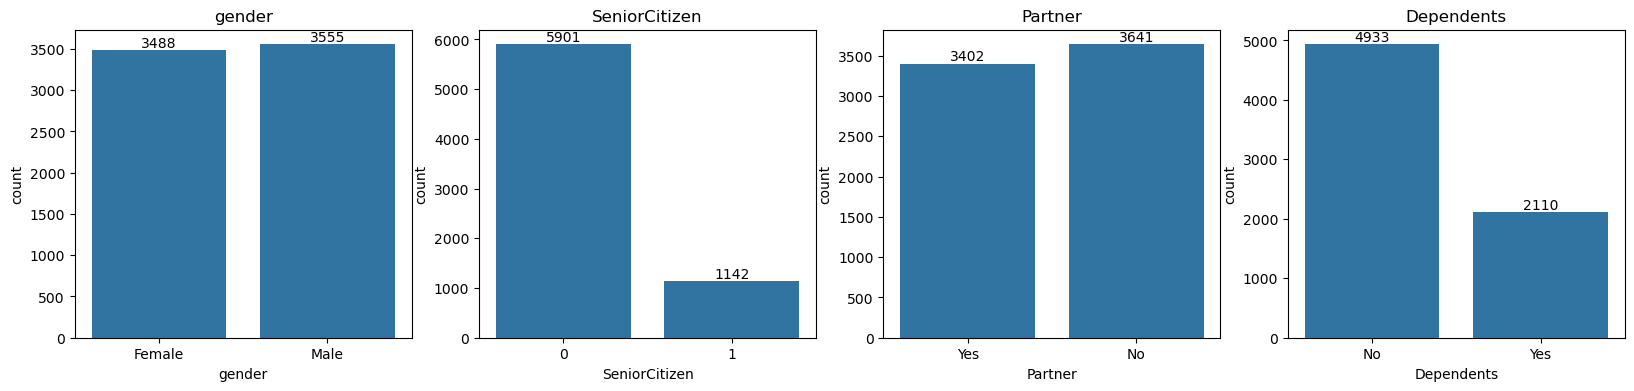

In [8]:
# Analyze demographic data points
numerical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical_cols):
    ax = plt.subplot(1, len(numerical_cols), i+1)
    sns.countplot(x=str(col), data=data)
    ax.set_title(f"{col}")

    # Display the actual value of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', # convert the float values into integer
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

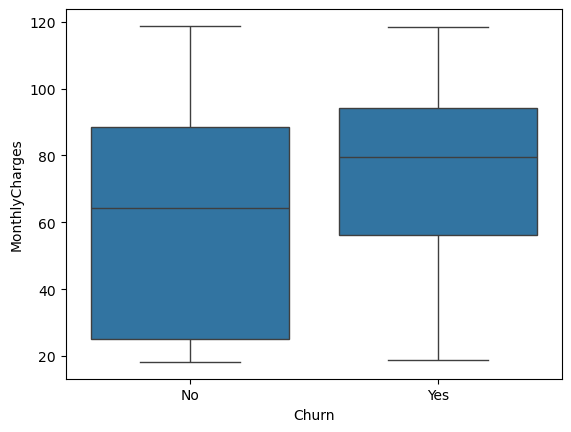

In [9]:
# Relationship between MonthlyCharges and Customer Churn using boxplot
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)

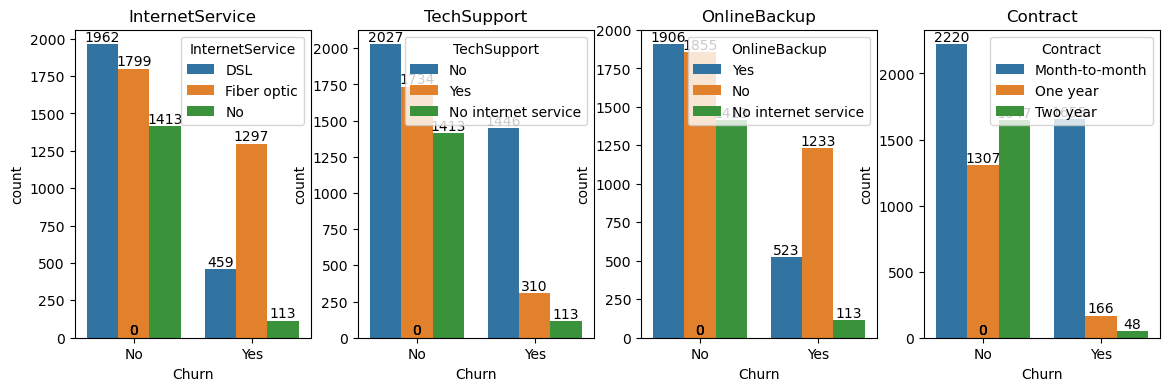

In [10]:
# Relationship between customer churn and a few other categorical variables(columns)
cols = ['InternetService', 'TechSupport', 'OnlineBackup', 'Contract']

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = data)
    ax.set_title(f"{col}")
    
    # Display the actual value of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', # convert the float values into integer
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

## Data Preprocessing ##

### Data cleaning ###

In [13]:
# Convert 'TotalCharges' datatype to numeric datatype
data['TotalCharges'] = data['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [14]:
# Take a look at all the categorical columns
categorical_features = data.drop(['customerID', 'TotalCharges', 'MonthlyCharges', 'SeniorCitizen', 'tenure'], axis=1)

categorical_features.head(7)

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
5,Female,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,Yes
6,Male,No,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),No


In [15]:
# Encoding the categorical features data
label_encode = preprocessing.LabelEncoder()
categorical_data = categorical_features.apply(label_encode.fit_transform)
categorical_data.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [16]:
# Merge the numerical dataframe and the encoded categorical dataframe
numerical_features = data[['customerID','TotalCharges','MonthlyCharges','SeniorCitizen','tenure']]
final_df = pd.merge(numerical_features, categorical_data, left_index=True, right_index=True)
final_df

,customerID,TotalCharges,MonthlyCharges,SeniorCitizen,tenure,gender,Partner,Dependents,PhoneService,MultipleLines,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,29.85,29.85,0,1,0,1,0,0,1,...,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,1889.50,56.95,0,34,1,0,0,1,0,...,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,108.15,53.85,0,2,1,0,0,1,0,...,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,1840.75,42.30,0,45,1,0,0,0,1,...,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,151.65,70.70,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1990.50,84.80,0,24,1,1,1,1,2,...,2,0,2,2,2,2,1,1,3,0
7039,2234-XADUH,7362.90,103.20,0,72,0,1,1,1,2,...,0,2,2,0,2,2,1,1,1,0
7040,4801-JZAZL,346.45,29.60,0,11,0,1,1,0,1,...,2,0,0,0,0,0,0,1,2,0
7041,8361-LTMKD,306.60,74.40,1,4,1,1,0,1,2,...,0,0,0,0,0,0,0,1,3,1


### Perform Oversampling ###

In [18]:
# Drop all the null values and unnecessary features
final_df = final_df.dropna()
final_df = final_df.drop(['customerID'],axis=1)

# Train-test split
X = final_df.drop(['Churn'],axis=1)
y = final_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Check for target feature imbalance in the training dataset
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

In [20]:
## Perform oversampling

# Number of nearest neighbors used to generate synthetic samples
oversample = SMOTE(k_neighbors=5)   

# Fit_resample performs two operations:
# 1. It fits the SMOTE model to the data, meaning it learns the distribution and relationships in the data
# 2. It then resamples the data, creating new synthetic examples of the minority class and returning the new feature set (X_smote) and target labels (y_smote)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# This line reassigns the resampled feature set (X_smote) and labels (y_smote) back to X_train and y_train, replacing the original imbalanced training data with the balanced one
X_train, y_train = X_smote, y_smote

In [21]:
# Check the number of samples in each class to ensure that they are equal
y_train.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

## Build the Customer Churn Prediction Machine Learning Model ##

#### Random Forest is used in this project. We can build several ML models and compare their performances, but for this project I just use Random Forest model for quick demonstration. ####

In [24]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=46)

# Fit the model with the training data
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=46)

## Model Evaluation ##

### Accuracy ###

In [27]:
# Make prediction
y_pred = rf_model.predict(X_test)

# Display the accuracy score of the model
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

Accuracy Score: 0.7697


### Precision ###

In [29]:
precision = precision_score(y_test, y_pred)

# Display the precision score of the model
print(f"Precision Score: {precision:.4f}")

Precision Score: 0.5665


### F1 Score ###

In [31]:
f1 = f1_score(y_test, y_pred)

# Display the F1 Score of the model
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5680


### Recall ###

In [33]:
recall = recall_score(y_test, y_pred)

# Display the Recall Score of the model
print(f"Recall Score: {recall:.4f}")

Recall Score: 0.5695


### Precision-Recall AUC ###

In [35]:
# Compute precision and recall values
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred)

# Display the Recall Score of the model
print(f"Precision-Recall Score: {auc(recall_values, precision_values):.4f}")

Precision-Recall Score: 0.6252


### ROC-AUC ###

In [37]:
# Predict the probabilities for the positive class (class=1)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Get the probability for the positive class (churn)

# Display the ROC-AUC Score of the model
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

ROC-AUC Score: 0.8081


Based on the model evaluation results, we can conclude that the machine learning model is performing as expected. The relatively low performance is likely due to the small size of the dataset. It is believed that with a larger dataset, the model would likely achieve better performance.